## Question 002

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('palm_ffb.csv')

In [17]:
# check data
data.head()

,Date,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
0,01.01.2008,616.4,25.306452,21.3,32.2,184.4,25,777778.3951,1.62
1,01.02.2008,568.9,26.165517,20.9,35.1,140.2,23,767988.2759,1.45
2,01.03.2008,577.6,25.448387,21.3,32.9,280.4,25,783951.9231,1.56
3,01.04.2008,581.1,26.903333,20.6,34.8,173.3,25,788987.0504,1.39
4,01.05.2008,545.4,27.241935,20.9,35.0,140.6,25,813659.7222,1.44


In [19]:
# check data shape
data.shape
print('Rows and Columns: ', data.shape)

# check numeric 
num_vars = [var for var in data.columns if data[var].dtypes != 'O']
print('Number of numerical variables: ', len(num_vars))

# check missing value
data.isnull().any()

Rows and Columns:  (130, 9)
Number of numerical variables:  8


Date             False
SoilMoisture     False
Average_Temp     False
Min_Temp         False
Max_Temp         False
Precipitation    False
Working_days     False
HA_Harvested     False
FFB_Yield        False
dtype: bool

In [20]:
# descriptive statistics
data.describe()

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,527.646923,26.849918,21.379231,33.851538,188.980769,24.753846,793404.491565,1.602231
std,57.367844,0.651413,0.688971,1.079638,80.237210,1.239289,34440.893854,0.281751
min,380.700000,25.158065,18.900000,31.100000,2.000000,21.000000,683431.944400,1.080000
25%,488.625000,26.442285,21.000000,33.100000,140.300000,24.000000,768966.949100,1.390000
50%,538.300000,26.930645,21.500000,33.900000,182.150000,25.000000,790036.158050,1.585000
75%,571.025000,27.270726,21.800000,34.600000,226.100000,26.000000,821989.235250,1.807500
max,647.300000,28.580000,22.600000,36.000000,496.100000,27.000000,882254.225400,2.270000


In [22]:
# identify the distribution
def palm_ffb_stats(column):
    mean = round(column.mean(), 2)
    median = round(column.median(), 2)
    variance = round(column.var(), 2)
    std_dev = round(column.std(), 2)
    return mean, median, variance, std_dev

table = pd.DataFrame(columns=['Variable', 'Mean', 'Median', 'Variance', 'Standard Deviation'])

for var in num_vars:
    mean, median, variance, std_dev = palm_ffb_stats(data[var])
    table = table.append({'Variable': var, 'Mean': mean, 'Median': median, 'Variance': variance, 'Standard Deviation': std_dev}, ignore_index=True)

print(table)

        Variable       Mean     Median      Variance  Standard Deviation
0   SoilMoisture     527.65     538.30  3.291070e+03               57.37
1   Average_Temp      26.85      26.93  4.200000e-01                0.65
2       Min_Temp      21.38      21.50  4.700000e-01                0.69
3       Max_Temp      33.85      33.90  1.170000e+00                1.08
4  Precipitation     188.98     182.15  6.438010e+03               80.24
5   Working_days      24.75      25.00  1.540000e+00                1.24
6   HA_Harvested  793404.49  790036.16  1.186175e+09            34440.89
7      FFB_Yield       1.60       1.58  8.000000e-02                0.28


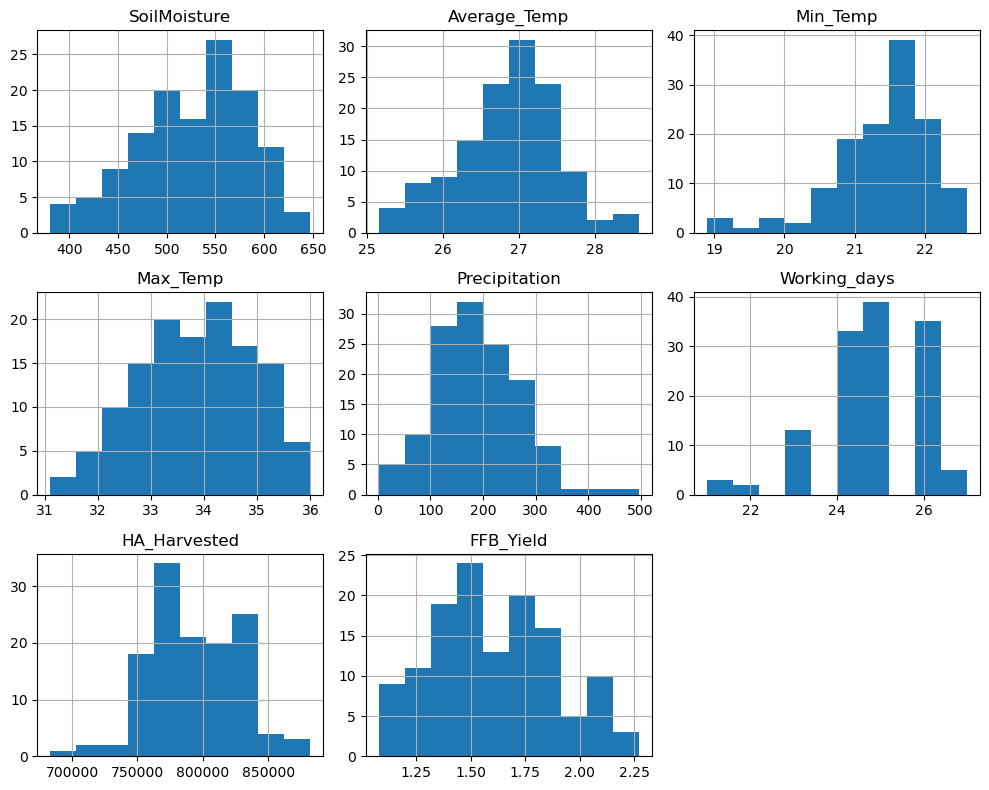

In [23]:
# plot histograms for each additive
data.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

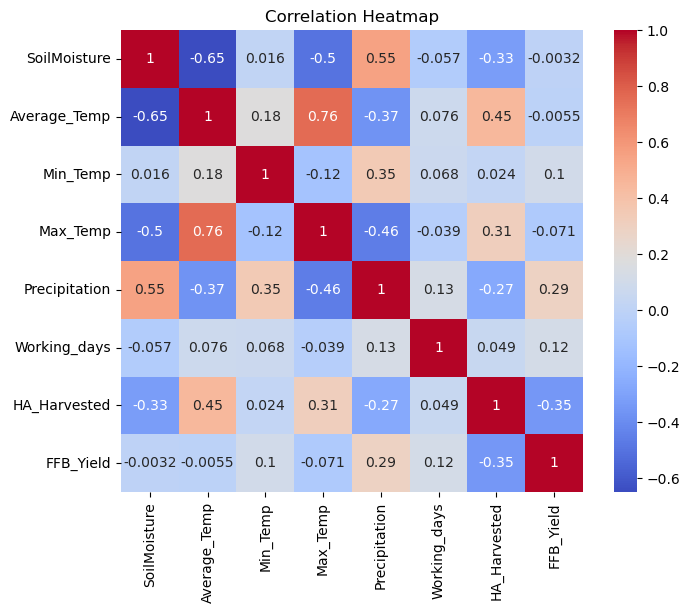

In [25]:
# create a heatmap of the correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [43]:
# correlation score with target variable
correlation = data[num_vars].corr()
correlation_scores = abs(correlation['FFB_Yield']).sort_values(ascending=False)

correlation_data = pd.DataFrame({'Feature': correlation_scores.index, 'Correlation Score': correlation_scores.values})
print(correlation_data)

         Feature  Correlation Score
0      FFB_Yield           1.000000
1   HA_Harvested           0.350222
2  Precipitation           0.289604
3   Working_days           0.116364
4       Min_Temp           0.103830
5       Max_Temp           0.071201
6   Average_Temp           0.005494
7   SoilMoisture           0.003183


In [60]:
# variable settings for feature importances
independent = data.drop(['FFB_Yield','Date'],axis=1) # independent variables
target = data.FFB_Yield # target variable

In [61]:
# apply XGBRegressor object
feature_names = independent.columns
X_train, X_test, y_train, y_test = train_test_split(independent, target, test_size=0.2, random_state=42)

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

In [63]:
# retrieve and print the feature importances for XGBRegressor object
importance_scores_xgb = xgb.feature_importances_
sorted_importances = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['Importance'])
sorted_importances.index.name = 'Feature'
sorted_importances.sort_values(by='Importance', ascending=False, inplace=True)
print(sorted_importances)

               Importance
Feature                  
HA_Harvested     0.315233
Precipitation    0.257543
Average_Temp     0.106424
Max_Temp         0.099421
Working_days     0.083552
Min_Temp         0.076000
SoilMoisture     0.061828


In [66]:
# perform feature selection
k = 5  # select the top k features
selector = SelectKBest(score_func=f_regression, k=k)
independent_selected = selector.fit_transform(independent, target)
mask = selector.get_support()
feature_names = independent.columns[mask]
X_train, X_test, y_train, y_test = train_test_split(independent_selected, target, test_size=0.2, random_state=42)

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

In [68]:
# print the feature selection results
print("Selected Features:")
for feature in feature_names:
    print(feature)

# print the feature importance scores
print("Feature Importance Scores:")
for feature, importance in zip(feature_names, importance_scores):
    print(f"{feature}: {importance}")

# print the model evaluation metrics
print("Model Evaluation Metrics:")
print("R-squared:", r2)
print("Mean Squared Error:", mse)

Selected Features:
Min_Temp
Max_Temp
Precipitation
Working_days
HA_Harvested
Feature Importance Scores:
Min_Temp: 0.08158059418201447
Max_Temp: 0.20039434731006622
Precipitation: 0.26272764801979065
Working_days: 0.10862363129854202
HA_Harvested: 0.34667375683784485
Model Evaluation Metrics:
R-squared: 0.29708710931642757
Mean Squared Error: 0.0610516238977579


In [69]:
# apply RandomForestRegressor object
rfr = RandomForestRegressor()
sfs_model = sfs(rf, k_features='best', forward=True, verbose=2, scoring='r2', cv=5)

# perform feature selection
sfs_model.fit(independent, target)
feature_names = list(sfs_model.k_feature_names_)
rfr.fit(independent[feature_names], target)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.4s finished

[2023-07-12 03:20:01] Features: 1/7 -- score: -0.15294269045686462[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.2s finished

[2023-07-12 03:20:03] Features: 2/7 -- score: -0.18222834643105695[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished

[2023-07-12 03:20:05] Features: 3/7 -- score: 0.09264676361011855[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

RandomForestRegressor()

In [70]:
# retrieve and print the feature importance scores from the RandomForestRegressor
importance_scores_rfr = rfr.feature_importances_

# print the feature selection results
print("Selected Features:")
for feature in feature_names:
    print(feature)

# print the feature importance scores
print("Feature Importance Scores:")
for feature, importance in zip(feature_names, importance_scores):
    print(f"{feature}: {importance}")

Selected Features:
SoilMoisture
Min_Temp
Precipitation
Working_days
HA_Harvested
Feature Importance Scores:
SoilMoisture: 0.08158059418201447
Min_Temp: 0.20039434731006622
Precipitation: 0.26272764801979065
Working_days: 0.10862363129854202
HA_Harvested: 0.34667375683784485


## Summary
- XGBRegressor feature selection are Min_Temp, Max_Temp, Precipitation, Working_days, HA_Harvested
- RandomForestRegressor feature selection are SoilMoisture, Min_Temp, Precipitation, Working_days, HA_Harvested